# **Learning Problem Definition — Ride Price Estimation**                 

This project defines a supervised machine learning problem where the goal is to predict ride price from trip and context features such as distance, duration, time of day, traffic, weather, and demand level. Since the target value (ride price) is numeric and continuous, the main task is a regression problem, with an additional derived classification task for high-cost vs low-cost rides.

This problem is better solved using machine learning rather than fixed rules because ride pricing depends on multiple interacting factors. Creating manual rules for every combination of traffic, demand, time, and weather would be complex and rigid. A machine learning model can automatically learn these relationships from data and adapt its predictions based on patterns instead of hand-written formulas.

The model is expected to learn how each feature and combination of features influences ride price, including which factors increase or decrease cost and by how much. After training, it should generalize these learned patterns to estimate prices for new rides it has not seen before.

**Dataset Design & Feature Justification**

The dataset was designed to represent realistic ride conditions and pricing behavior.

Distance (km) affects price because longer trips cost more to operate.
Trip duration (minutes) matters because time-based pricing is common.
Time of day influences price due to peak vs off-peak hours.
Traffic level affects cost by increasing delay and fuel use.
Weather condition impacts demand and operating difficulty.
Demand level supports surge-style pricing behavior.

One feature considered but not included was fuel price. It was excluded because fuel price changes slowly over time and would likely be constant across many rides, giving little useful variation for the model within this dataset.

In [37]:
import numpy as np

In [38]:
import pandas as pd

# Data Exploration & Understanding

In [39]:
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv("/rides.csv")   #Load datasets

In [41]:
df.head()    #View the first rows

,distance_km,duration_min,time_of_day,traffic_level,weather,demand_level,ride_price
0,15.18,76.3,night,low,clear,low,61.06
1,25.49,46.7,morning,low,clear,surge,108.20
2,1.00,73.7,morning,medium,rainy,low,35.41
3,11.28,53.1,night,low,clear,surge,80.52
4,5.99,34.3,night,medium,clear,normal,37.16


In [42]:
df.shape    # Check rows and columns



(200, 7)

In [43]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    200 non-null    float64
 1   duration_min   200 non-null    float64
 2   time_of_day    200 non-null    object 
 3   traffic_level  200 non-null    object 
 4   weather        200 non-null    object 
 5   demand_level   200 non-null    object 
 6   ride_price     200 non-null    float64
dtypes: float64(3), object(4)
memory usage: 11.1+ KB


In [44]:
df.isnull().sum()


,0
distance_km,0
duration_min,0
time_of_day,0
traffic_level,0
weather,0
demand_level,0
ride_price,0


In [45]:
df.describe()


,distance_km,duration_min,ride_price
count,200.000000,200.00000,200.000000
mean,17.502300,44.93100,83.680600
std,10.413777,21.01531,42.142751
min,1.000000,5.00000,10.260000
25%,7.867500,28.17500,52.722500
50%,19.025000,46.00000,78.255000
75%,26.410000,63.95000,108.170000
max,34.910000,79.50000,228.860000


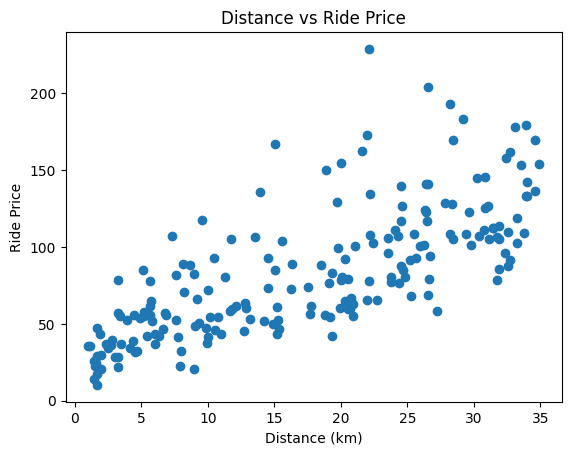

In [46]:
plt.scatter(df['distance_km'], df['ride_price'])
plt.xlabel("Distance (km)")
plt.ylabel("Ride Price")
plt.title("Distance vs Ride Price")
plt.show()


# Data Cleaning & Feature Engineering

In [47]:
for col in ['traffic_level', 'weather']:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-2884331856.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [48]:
df_encoded = pd.get_dummies(
    df,
    columns=['time_of_day', 'traffic_level', 'weather', 'demand_level'],
    drop_first=True
)


In [49]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numeric_features = ['distance_km', 'duration_min']
df_encoded[numeric_features] = scaler.fit_transform(
    df_encoded[numeric_features]
)

In [50]:
Q1 = df_encoded['ride_price'].quantile(0.25)
Q3 = df_encoded['ride_price'].quantile(0.75)
IQR = Q3 - Q1

df_encoded = df_encoded[
    (df_encoded['ride_price'] >= Q1 - 1.5 * IQR) &
    (df_encoded['ride_price'] <= Q3 + 1.5 * IQR)
]


# Regression Model (Linear Regression)

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X = df_encoded.drop('ride_price', axis=1)
y = df_encoded['ride_price']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [54]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [55]:
from sklearn.metrics import mean_absolute_error

y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae


7.578692410507517

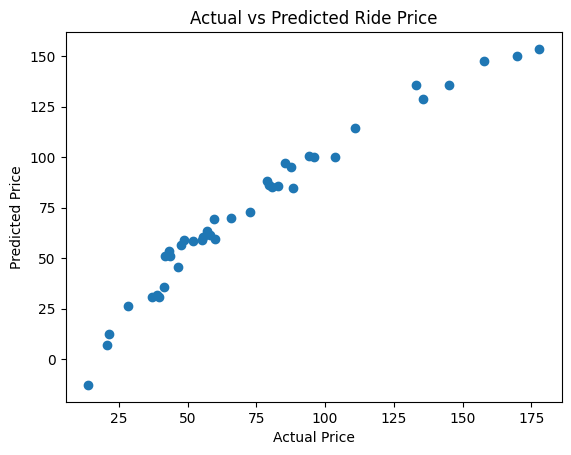

In [56]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Ride Price")
plt.show()


# Classification (Logistic Regression)

In [57]:
model.coef_


array([ 31.31779672,   9.49251893,  13.46389744,  -3.34463675,
         8.47866229, -31.84852829, -17.23963443,   8.10588585,
        23.4710019 ,   7.05744777,  46.68474425])

In [58]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Impact": model.coef_
}).sort_values(by="Impact", ascending=False)

coefficients


,Feature,Impact
10,demand_level_surge,46.684744
0,distance_km,31.317797
8,weather_storm,23.471002
2,time_of_day_evening,13.463897
1,duration_min,9.492519
4,time_of_day_night,8.478662
7,weather_rainy,8.105886
9,demand_level_normal,7.057448
3,time_of_day_morning,-3.344637
6,traffic_level_medium,-17.239634


In [59]:
df["high_cost"] = (df["ride_price"] > df["ride_price"].median()).astype(int)


In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
X_class = X
y_class = (df_encoded["ride_price"] > df_encoded["ride_price"].median()).astype(int)

In [62]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

clf = LogisticRegression()
clf.fit(X_train_c, y_train_c)

LogisticRegression()

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [64]:
preds = clf.predict(X_test_c)

In [65]:
accuracy_score(y_test_c, preds)
confusion_matrix(y_test_c, preds)

array([[23,  0],
       [ 0, 17]])